In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import welch
from sklearn.decomposition import PCA

data = loadmat("C:\\Users\\bnola\\Documents\\Data Analysis\\eeg.mat")
hd,hdh=data['hd'],data['hdh']
rec,rech=data['rec'],data['rech'][0]
rech = rech[:2830]
fs = 100
fs_hyp = 1/30.0
int_fs = int(fs/fs_hyp)


Following what we did in the previous assignment, build a matrix that contains in each row the power spectrum of each successive segment of data of length 3,000. To correct for possible drifts in the mean EEG signal, subtract from each of these segments its mean.  We save the resulting power spectrum in decibels (i.e. we take the logarithm in base 10, log10, and multiply the result by 10).

In [2]:
spect =  []
#this is a variant of what we did in class. Instead of cycling through rech, we cycle through rec[1,:] in steps of int_fs=3000

for i in range(0,len(rec[1,:]),int_fs):   
    signal = rec[1,i:i+int_fs]
    f,p = welch(signal-np.mean(signal), fs=fs) 
    spect.append(10.*np.log10(p)) #we save the spectral power in decibels

#Convert to array for later convenience
spect = np.array(spect)

Now you are ready to pass this information to the PCA algorithm. First, though, see by yourself what the data looks like. Plot individual power spectra (from different random rows in your matrix) and see that they are messy and potentially different from one another in specific ways. In what ways? What are the essential differences that collectively separate these different spectra in separate classes that could signal different brain states? This is what PCA allows us to do.

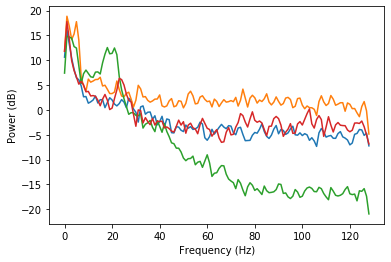

In [3]:
for rdm in [100, 467, 1005, 2001]: 
    plt.plot(spect[rdm])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB)')

## Exercise 1

a) Run the PCA with **PCA** on the power spectra matrix and first plot the percent of variance explained by each principal component. How many components do you think are necessary to sufficiently explain the data?

Hint: If you don’t specify how many principal components you want to have, you might end up with a lot of them. That’s OK - but for better visualization try to inspect the first 10. Remember that the first principal component (PC1) is the axis that explains more variance, PC2 comes after, and so on.

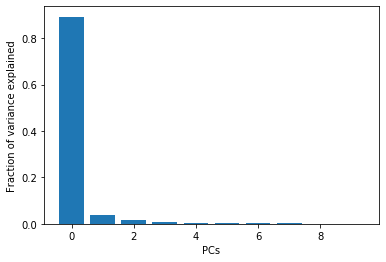

In [4]:
# Compute de PCA
pca=PCA()
pca.fit(spect)
latent = pca.explained_variance_
coeff = pca.components_
score = pca.transform(spect)
evr = pca.explained_variance_ratio_

# Plot fraction of variance of the first 10 PC
plt.bar(range(10), evr[:10])
plt.xlabel("PCs")
plt.ylabel("Fraction of variance explained")
plt.show()

The plot shows that the first principal component captures more than 80% of the variance in the data. The second principal component captures less than 10% of the variance, but still significant, and all the other principal components are neglegible. Our dataset is mostly bi-dimensional. All the features of the power spectra at different time points are decomposable in 2 main feature components.

b) Plot in a 2D graph each data point in the first and second principal components. What do you see? Could you easily separate the two main brain states, awake and asleep from this representation?

In [5]:
score

array([[-16.74328896, -17.53412499, -11.54351047, ...,   0.22818772,
         -0.47859134,  -0.19256546],
       [-28.22108528,  -2.22825328,  23.94949924, ...,  -0.7950164 ,
          0.14137922,  -0.32242608],
       [-38.65070647,   3.62867921,  28.57545934, ...,  -0.16965235,
         -0.18353054,  -0.29824159],
       ...,
       [ 48.74579992,   6.83127463,   6.77639858, ...,   0.47296255,
          0.40131792,   0.16264257],
       [ 39.2780532 ,   1.08135065,   1.74945933, ...,   0.17339265,
         -0.42926135,   0.344586  ],
       [ 19.85066491,   1.72294165,  -3.94781366, ...,   0.15315381,
         -0.16305452,   0.13917033]])

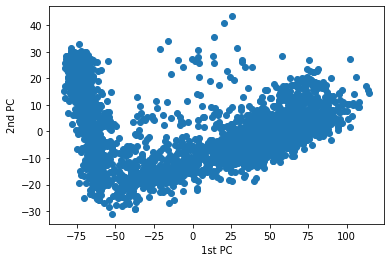

In [6]:
# Plot first against the second component
plt.scatter(score[:,0], score[:,1])
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.show()

from this representation we get the intuition that there are 2 different conditions, given by the 2 branches in the graph, but we cannot really know which one corresponds to awake and which one to asleep

c) Which PC do you think would be better to separate these two clouds?  Separate the two clouds based on a fixed value in the first principal component. Define this principal component through visual inspection in the above graph. Then replot that graph by using different colors for the two clouds that you separated.

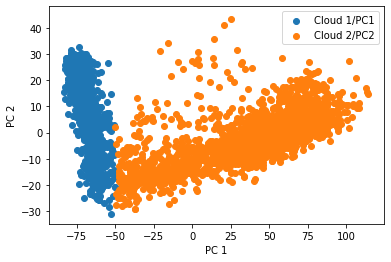

In [67]:
in1= score[:,0]<-50
in2= score[:,0]>-50

plt.scatter(score[in1,0], score[in1,1], label='Cloud 1/PC1')
plt.scatter(score[in2,0], score[in2,1], label='Cloud 2/PC2')
plt.legend()
plt.ylabel('PC 2')
plt.xlabel('PC 1')
plt.show()

Now average the spectra for all EEG pieces at each side of this boundary separately. Plot each of these two mean power spectra. Can you identify what cloud corresponds to the awake state and what cloud is more consistent with sleep?

Hint: To obtain the base of frequencies for the plot, you can run again **welch** on one of the 3,000-point EEG pieces passing the sampling frequency *fs* set to 100 Hz.


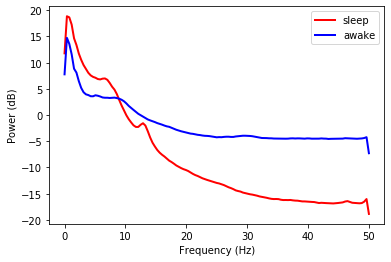

In [54]:
f,_ = welch(signal-np.mean(signal),fs=100)

plt.plot(f,np.mean(spect[in1],0),'r',label="sleep",linewidth=2)
plt.plot(f,np.mean(spect[in2],0),'b',label="awake",linewidth=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.legend()
plt.show()

We confirm that the two clouds identified by the 1st PC in the PCA correspond to the awake and sleep conditions, and that we can identify which cloud corresponds to each brain state based on the mean spectra of each cloud. The spectrum with higher power at low frequencies corresponds to the sleep state.

## Exercise 2

a) Knowing that the sleep phase contains separate brain states (REM, shallow NON-REM, deep NON-REM), you can try to see if PCA can distinguish those states by looking at the 2nd principal component. First zoom in your sleep cloud in the score plot and see if you can identify separate sub-clouds. Plot a histogram of the 2nd component score for the sleep points and see if you can identify separate subgroups. Do you see different modes on the distribution you got with the histogram?



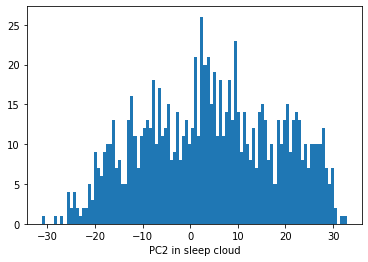

In [56]:
plt.hist(score[in1,1], bins=100)
plt.xlabel('PC2 in sleep cloud');

The histogram does not look clearly multimodal (indicating different subclusters) but there is a hint to one such structure, it clearly does not look very Gaussian (which would be the signature of a single cluster)


b) Perhaps you do not see very clearly the separation. The next thing you can do is to run again the PCA now restricted to the sleep spectra you identified in Exercise 1. This is a more powerful approach because, as mentioned in class, the 2nd component is forced to be orthogonal to the 1st component. In this new analysis this constraint is removed and now the direction that best distinguishes the sleep conditions can be evaluated without such restrictions. In this new PCA, plot now the fraction of explained variance in the two first principal components. 


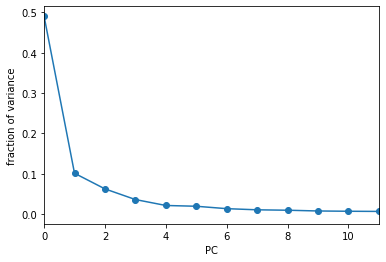

In [70]:
eeg_sleep = spect[in1,:]
pca=PCA()
pca.fit(eeg_sleep)
latent_sleep = pca.explained_variance_
coeff_sleep = pca.components_
score_sleep = pca.transform(eeg_sleep)
evr = pca.explained_variance_ratio_

#fraction of explained variance
plt.plot(evr,'o-')
plt.xlabel('PC')
plt.ylabel('fraction of variance')
plt.xlim([0,11])
plt.show()


Can you distinguish now 3 clouds? Use the histogram again, and play with the number of bins to see the 3 clouds more clearly. Can you visually determine the boundaries of each candidate sleep phase? 

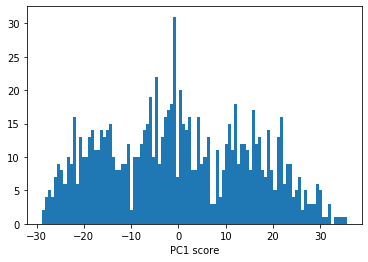

In [86]:
plt.hist(score_sleep[:,0],bins=100)
plt.xlabel('PC1 score')
plt.show()


Define the boundaries between phases by visual inspection. Then separate spectra corresponding to each cloud and average them together to obtain 3 mean spectra for each cloud. Plot them. Can you identify the REM, shallow NON-REM, and deep NON-REM phases of sleep?

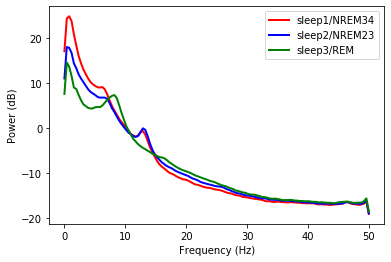

In [88]:
in_sleep1= score_sleep[:,0]<-10
in_sleep2= (score_sleep[:,0]>-10) & (score_sleep[:,0]<10)
in_sleep3= score_sleep[:,0]>10

plt.plot(f,np.mean(eeg_sleep[in_sleep1],0),'r',label="sleep1/NREM34",linewidth=2)
plt.plot(f,np.mean(eeg_sleep[in_sleep2],0),'b',label="sleep2/NREM23",linewidth=2)
plt.plot(f,np.mean(eeg_sleep[in_sleep3],0),'g',label="sleep3/REM",linewidth=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.legend();


Explain here what cloud corresponds to each sleep phase: **REM = PC1>10, NREM34 = PC1<-10 and 10>NREM23>-10**

## Exercise 3
You have now achieved your own classification of the phases of sleep-wake in this recording. Let's see how well we did in identifying sleep phases on our own, just with the help of the PCA algorithm, compared with the expert eye recorded in the hypnogram **rech**. To this end, get the indices that **rech** attributes to the REM stage, to the NON-REM stages 1 and 2, and to the NON-REM stages 3 and 4. Then plot again the 2D plot of PC1 against PC2 only that the dots are plotted with different color depending on the **rech** evaluation. Pretty good, eh?

Do this first for the sleep spectra PCA that we ran last:

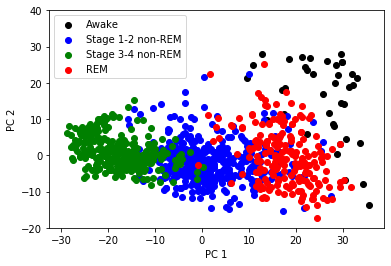

In [89]:
rech_sleep = rech[in1] # get the hypnogram scores for each data point in the "sleep cloud" of the 2nd PCA analysis

#plot the scores in the two first PCs, see the clouds?
#plt.scatter(score_sleep[:,0],score_sleep[:,1])
plt.scatter(score_sleep[rech_sleep==0 , 0], score_sleep[rech_sleep==0, 1], color='k', label="Awake")
plt.scatter(score_sleep[(rech_sleep==1) | (rech_sleep==2) , 0], score_sleep[(rech_sleep==1) | (rech_sleep==2), 1], color='b', label="Stage 1-2 non-REM")
plt.scatter(score_sleep[(rech_sleep==3) | (rech_sleep==4) , 0], score_sleep[(rech_sleep==3) | (rech_sleep==4), 1], color='g', label="Stage 3-4 non-REM")
plt.scatter(score_sleep[rech_sleep==5 , 0], score_sleep[rech_sleep==5, 1], color='r', label="REM")

plt.ylabel('PC 2')
plt.xlabel('PC 1')
plt.ylim(-20,40)
plt.legend()
plt.show()


Pretty good, eh? We confirm, as we predicted in Exercise 2b, that REM corresponds in our graph approximately to PC1>10, NREM34 corresponds to PC1<-10 and NREM23 is in-between. There are very few awake conditions in this plot because we excluded the larger cloud of the first, full PCA


Now we repeat this for the PCA that we ran first on the full data, including the awake cloud:

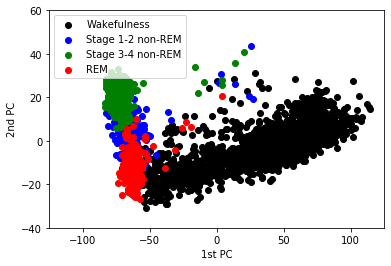

In [22]:
# Same as above, now coloring each of the sleeping stages. First for the whole data, including awake and sleep
plt.scatter(score[rech==0, 0], score[rech==0, 1], color='k', label="Wakefulness")
plt.scatter(score[(rech==1) + (rech==2), 0], score[(rech==1) + (rech==2), 1], color='b', label="Stage 1-2 non-REM")
plt.scatter(score[(rech==3) + (rech==4) , 0], score[(rech==3) + (rech==4), 1], color='g', label="Stage 3-4 non-REM")
plt.scatter(score[rech==5, 0], score[rech==5, 1], color='r', label="REM")
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.xlim(-125,125)
plt.ylim(-40,60)
plt.legend(loc=2)
plt.show()


we also see a nice separation of the phases, especially between sleep and awake. Instead, the separation of phases within sleep is not as good as above. We discussed in class that this was due to the imperfect separation by the 2nd PCA because of the imposition of orthogonality with the 1st PC.